# Hypothesis 1 - Wild animals

## Data loading, cleaning, EDA

load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import astral
import astral.geocoder
import astral.sun

import data_loader as dl
import logging

load data

In [2]:
df = dl.load_data(2021, 2021)
columns = ['date', 'time', 'druh nehody', 'lokalita nehody', 'reg']
df = df[columns]
df = df.replace({0: np.NAN})

df['zver'] = df['druh nehody'] == 5  # srážkas lesní zvěří
df['obec'] = df['lokalita nehody'] == 1  # obec

df['date'] = pd.to_datetime(df['date'])
df['datetime'] = df['date'] + df['time']  # to datetime
df = df[~(df['time'].isna())]  # remove unknown time, small percent only

df = df.drop(columns=['druh nehody', 'lokalita nehody'])

Basic overwiev

### Wild animals vs locality relationship
In this figure we can see, that most of accident caused by wild animals happen outside of municipality. It is more than
95%.

Percent of accidents caused by wild animals outside of municipality: 98.05527123848516


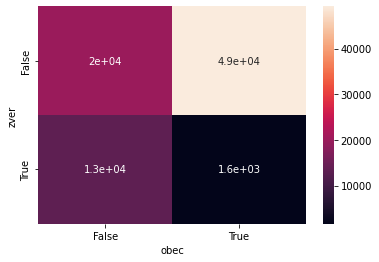

In [3]:
zver_obec_ct = pd.crosstab(df['zver'], df['obec'])
sns.heatmap(zver_obec_ct, annot=True)

df_zver = df[df['zver']]
mimo_obec_percent = 100 - (df_zver['obec'].sum() / len(df) * 100)
print(f"Percent of accidents caused by wild animals outside of municipality: {mimo_obec_percent}")

### Wild animals vs time

Add sunrise, sunset information.

In [4]:
city = astral.geocoder.lookup('Prague', astral.geocoder.database())


def sunrise_sunset_time(date):
    """
    sunrise - The time in the morning when the top of the sun breaks the horizon
        (asuming a location with no obscuring features.)
    sunset - The time in the evening when the sun is about to disappear below the horizon
        (asuming a location with no obscuring features.)
    """
    astral_data = astral.sun.sun(city.observer, date=date, tzinfo='Europe/Prague')
    sr = astral_data['sunrise'].replace(tzinfo=None)
    ss = astral_data['sunset'].replace(tzinfo=None)

    return sr, ss


astral_df = pd.DataFrame(pd.unique(df['date']), columns=['date'])
astral_df[['sunrise_time', 'sunset_time']] = astral_df['date'].apply(sunrise_sunset_time).apply(pd.Series)
df = df.merge(astral_df, left_on='date', right_on='date')


Plot number of accidents per month per hour. As most of accidents happen outside of municipality, only these accidents are considered.
Wild animal accidents is dependent on sunrise/sunset, but way more important is weather it is night or daylight.

In [5]:
df['hour'] = df['datetime'].dt.round('1h').dt.hour  # <12:30 - 13:30) -> 13
df['month'] = df['datetime'].dt.month_name()
months = pd.unique(df['month'])

month_sr_ss = df.loc[:, ['date', 'month', 'sunrise_time', 'sunset_time']]
month_sr_ss.loc[:, 'sunrise_time'] = month_sr_ss.loc[:, 'sunrise_time'].dt.hour + (
        month_sr_ss.loc[:, 'sunrise_time'].dt.minute / 60)
month_sr_ss.loc[:, 'sunset_time'] = month_sr_ss.loc[:, 'sunset_time'].dt.hour + (
        month_sr_ss.loc[:, 'sunset_time'].dt.minute / 60)
month_sr_ss = month_sr_ss.groupby(month_sr_ss['month']).mean().reset_index()

df_r = df.loc[df['obec'] == 0, ['month', 'hour', 'zver']]
df_r = df_r.groupby(['hour', 'month', ])['zver'].agg(['sum', 'count'])

df_r['zver_ration'] = (df_r['sum'] / df_r['count']) * 100
df_r.reset_index(inplace=True)

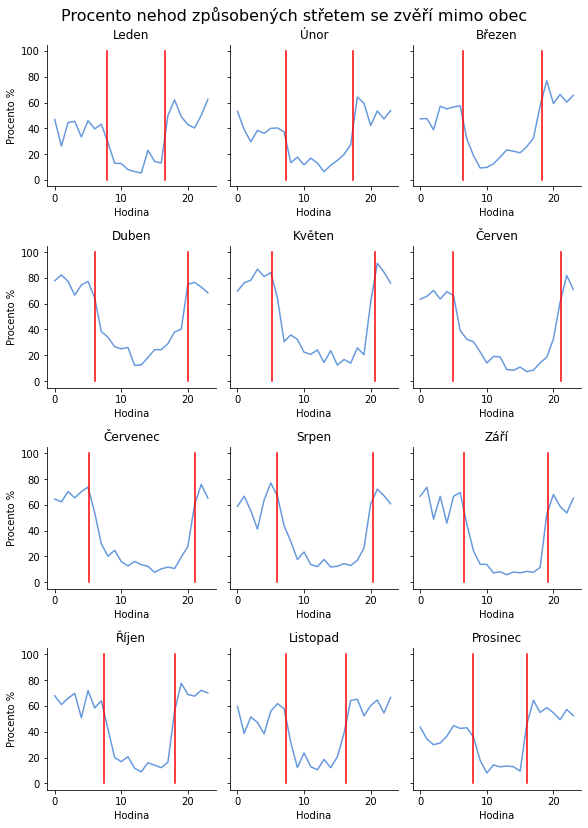

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(8.27, 11.69), sharey=True)
fig.suptitle("Procento nehod způsobených střetem se zvěří mimo obec", fontsize=16)
axes = axes.flatten()

month_dict = {"January": "Leden", "February": "Únor", 'March': "Březen", "April":"Duben",
             "May": "Květen", "June": "Červen", "July": "Červenec", "August": "Srpen", "September": "Září",
             "October": "Říjen", "November": "Listopad", "December": "Prosinec"}
for i, month in enumerate(months):
    df_m = df_r.loc[df_r['month'] == month]
    df_m.plot(x="hour", y='zver_ration', ax=axes[i], color="#69d")
    month_sr_ss_m = month_sr_ss[month_sr_ss['month'] == month]
    axes[i].plot([month_sr_ss_m.iloc[0:, 1], month_sr_ss_m.iloc[0:, 1]], [0, 100], color='red')
    axes[i].plot([month_sr_ss_m.iloc[0:, 2], month_sr_ss_m.iloc[0:, 2]], [0, 100], color='red')

    axes[i].set(ylabel="Procento %", xlabel='Hodina')
    axes[i].set_title(month_dict[month])
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
    axes[i].tick_params(axis='x')
    axes[i].get_legend().remove()

fig.tight_layout()
fig.savefig('./img/wild_animals_time.png')

Add information about night.

In [7]:
def mark_night(df: pd.DataFrame):
    df['night'] = ~((df['sunrise_time'] < df['datetime']) | (df['datetime'] > df['sunset_time']))
    return df


df = mark_night(df)

### Correlations
Check all three (wild animal, municipality, night) descriptors correlatins.
We can see, that there is a correlation between wild annimal and munnicipality. The correlation between wild animal and
night is weaker.

<AxesSubplot:>

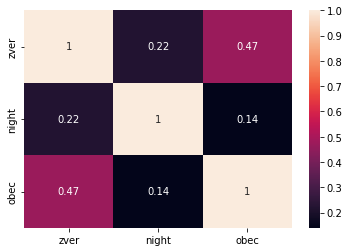

In [8]:
df = df.loc[:, ['zver', 'night', 'obec']]
df_corr = df.corr().round(decimals=2)
sns.heatmap(df_corr.abs(), annot=True)

## Modeling

Prepare dataset. No normalization needed, because values are 0 or 1.

In [9]:
df['night'] = df['night'].astype('Int64')
df['obec'] = df['obec'].astype('Int64')

total = len(df)
trail_len = int(0.8 * total)
train = df[:trail_len]
val = df[trail_len:]


As we have two binary inputs, the solution should be separable be either a line or circle (both have the same accuracy). The space is basicallly a 2D cube with values in edges, so the regression should seperate these edges into two groups with n and m edges in each. 

The SVC classification has been selected.

In [10]:
cols = ['night', 'obec']


def predict(C=1.0, kernel='rbf'):
    model = SVC(C=C, kernel=kernel).fit(train[cols].values, train['zver'].values.reshape(-1, 1))
    expected = val['zver'].values.reshape(-1, 1)
    predicted = model.predict(val[cols].values)
    return metrics.accuracy_score(expected, predicted)


print(f"Round accuracy: {predict(kernel='rbf')}%", f"\nLinear accuracy: {predict(kernel='linear')}%")

/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Round accuracy: 0.8070217197262719% 
Linear accuracy: 0.8070217197262719%


The C value does not affects result. With only two descriptors we can determine, weather an accident was caused by wild animal, or not.
The accuracy is 81%.

/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A 

<AxesSubplot:>

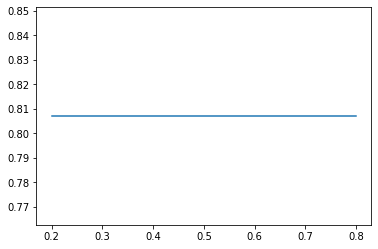

In [11]:
const = 1.0
consts = []
accuracies = []
for _ in range(0, 4):
    const = const - 0.2
    consts.append(const)
    a = predict(C=const)
    accuracies.append(a)

sns.lineplot(consts, accuracies)

In [12]:
predict(C=const)

/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8070217197262719

In [14]:
model = SVC(kernel='linear').fit(train[cols].values, train['zver'].values.reshape(-1, 1))
expected = val['zver'].values.reshape(-1, 1)
predicted = model.predict(val[cols].values)

/home/awesome/anaconda3/envs/oznal_conda/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<AxesSubplot:>

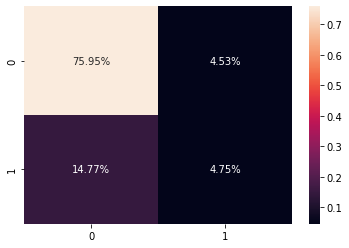

In [19]:
confussion_mx = metrics.confusion_matrix(expected, predicted)
sns.heatmap(confussion_mx / np.sum(confussion_mx), annot=True, fmt='.2%')

In [28]:
# night, obec
print(model.predict([[1, 0]])) # true
print(model.predict([[1, 1]])) # false
print(model.predict([[0, 0]])) # false
print(model.predict([[0, 1]])) # false

[ True]
[False]
[False]
[False]
